## ДЗ (необязательное)

1. Написать свой класс для модели линейной регрессии.
2. Описать метод predict() для использования обученной модели.
3. Решить проблему масштабирования данных: для корректной работы алгоритма данные должны быть нормированы, но для дальнейшего прогнозирования данные должны подаваться в исходном не отмасштабированном виде.
4. Модель должна работать с данными любой размерности (любым количеством признаков).
5. Операции должны быть максимально векторизованы (то есть не нужно в цикле проходить по всем объектам, а нужно одновременно обрабатывать все в матричном виде).

Сгенерируем данные с помощью pygame

pygame 2.1.2 (SDL 2.0.18, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


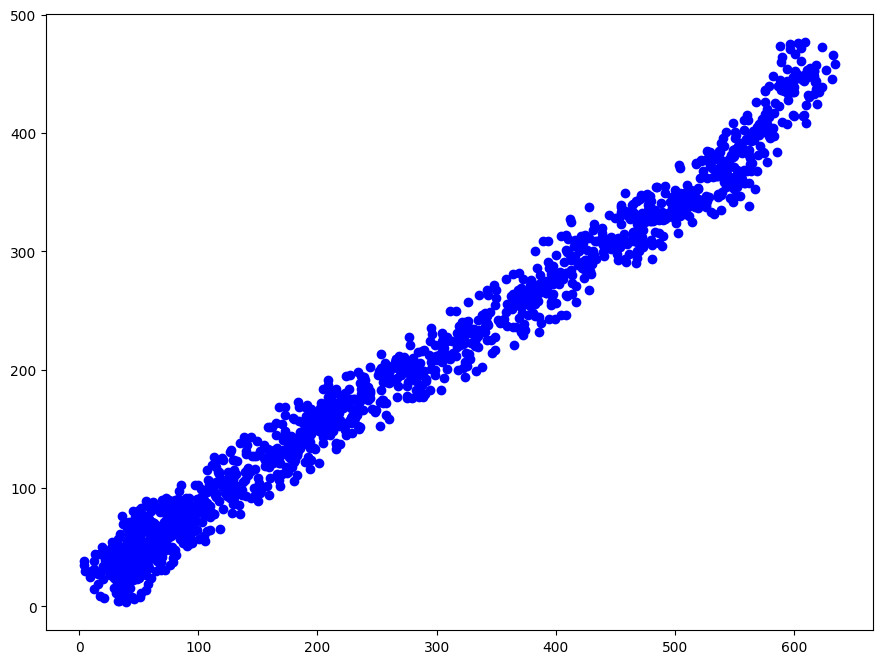

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygame

points = {'data':np.empty((0,1), dtype='f'), 'targets':np.empty((0,), dtype='f')}

c_radius = 3
c_color = (0,0,255)
c_thickness = 0
jet_radius = 30
jet_thr = .5

bg_color = (255,255,255)
(width,height) = (640,480)
screen = pygame.display.set_mode((width,height))
pygame.display.set_caption("data generator")

running = True
pushing = False
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            pushing = True
        elif event.type == pygame.MOUSEBUTTONUP:
            pushing = False

    if pushing and np.random.uniform(0,1)>jet_thr:
        (x, y) = pygame.mouse.get_pos()
        r = np.random.uniform(0,jet_radius)
        phi = np.random.uniform(0,2*np.pi)
        coord = [x+r*np.cos(phi), height-(y+r*np.sin(phi))]
        points['data'] = np.append(points['data'], [[coord[0]]], axis=0)
        points['targets'] = np.append(points['targets'], coord[1])

    screen.fill(bg_color)
    for X,y in zip(points['data'], points['targets']):
        pygame.draw.circle(screen,c_color,(int(X[0]),height-int(y)),c_radius,c_thickness)
    pygame.display.flip()

pygame.quit()

fig = plt.figure(figsize=(width/60,height/60))
plt.scatter(points['data'][:,0],points['targets'],c="blue")
plt.show()

Сохраним сгенерированные данные в файл, чтобы их можно было повторно использовать

In [2]:
np.save('points_data.npy', points['data'])
np.save('points_targets.npy', points['targets'])

Загрузим сохраненные данные из файла

In [3]:
pygame_x = np.load('points_data.npy')
pygame_y = np.load('points_targets.npy')

Разделим данные на обучающую и тестовую выборки

In [7]:
from sklearn.model_selection import train_test_split

pygame_x_train, pygame_x_test, pygame_y_train, pygame_y_test = train_test_split(pygame_x, pygame_y, test_size=0.2)

Создадим класс линейной регрессии.

Класс линейной регрессии поддерживает постепенное уменьшение шага градиентного спуска. На каждой итерации текущий шаг градиентного спуска умножается на step_multiplier. По умолчанию step_multiplier == 1 и шаг градиентного спуска неизменен.

Параметр eps нужен для определения сходимости градиентного спуска. Если разница между полученным на какой-то итерации значением ошибки и предыдущим меньше, чем eps, то

In [148]:
def mse(a: np.ndarray, b: np.ndarray):
    return ((a - b) ** 2).sum() / a.shape[0]


class MyLinearRegression:
    def __init__(self, step=0.01, max_steps=1000, eps=1e-4, step_multiplier=1, warnings_enabled=True):
        self._step = step
        self._max_steps = max_steps
        self._eps = eps
        self._weights = None
        self._step_multiplier = step_multiplier
        self._warnings_enabled = warnings_enabled


    def fit(self, x: np.ndarray, y: np.ndarray):
        current_step = self._step
        x = self._prepare_initial(x)
        self._weights = np.random.randn(x.shape[1])
        old_mse = float('inf')
        gradient_descent_converged = False
        for i in range(self._max_steps):
            prediction = self._predict_prepared(x)
            new_mse = mse(y, prediction)
            if abs(new_mse - old_mse) < self._eps:
                gradient_descent_converged = True
                break
            old_mse = new_mse

            gradients = self._compute_gradients(x, y, prediction)
            self._weights -= gradients * current_step
            current_step *= self._step_multiplier

        if not gradient_descent_converged and self._warnings_enabled:
            print("Gradient descent didn't converge")

        return self


    def _compute_gradients(self, x: np.ndarray, y: np.ndarray, prediction: np.ndarray):
        return (-2 / x.shape[0]) * ((y - prediction) @ x)


    def predict(self, x: np.ndarray):
        x_normalized = self._prepare(x)
        return self._predict_prepared(x_normalized)


    def _predict_prepared(self, x: np.ndarray):
        return x @ self._weights


    @property
    def intercept_(self):
        return self._weights[-1]


    @property
    def coef_(self):
        return self._weights[:-1]


    # noinspection PyArgumentList
    def _normalize_initial(self, x: np.ndarray):
        columnwise_min = x.min(axis=0)
        columnwise_max = x.max(axis=0)
        columnwise_delta = columnwise_max - columnwise_min

        self._normalization_min = columnwise_min
        self._normalization_delta = columnwise_delta

        return self._normalize(x)


    def _normalize(self, x: np.ndarray):
        # Needed to avoid potential division by 0 errors. Source: https://stackoverflow.com/questions/26248654/how-to-return-0-with-divide-by-zero
        return np.divide(x - self._normalization_min, self._normalization_delta, out=np.zeros_like(x), where=self._normalization_delta != 0)


    def _prepare(self, x: np.ndarray):
        return np.column_stack([self._normalize(x), np.ones(x.shape[0])])


    def _prepare_initial(self, x: np.ndarray):
        return np.column_stack([self._normalize_initial(x), np.ones(x.shape[0])])

16.629009170153246 [420.89445689]


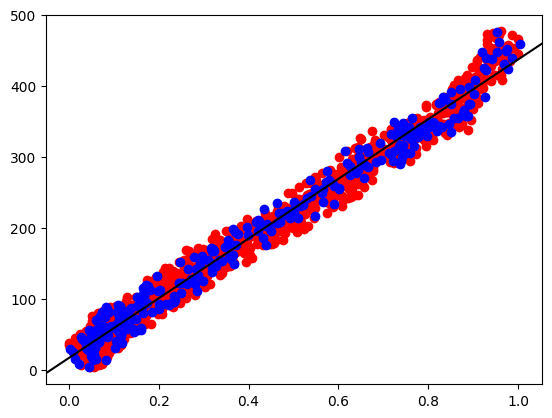

In [28]:
lr = MyLinearRegression(step=0.1).fit(pygame_x_train, pygame_y_train)
#print(lr.score(x, y))
print(lr.intercept_, lr.coef_)

plt.scatter(lr._prepare(pygame_x_train)[:, :-1], pygame_y_train, c='red')
plt.scatter(lr._prepare(pygame_x_test)[:, :-1], pygame_y_test, c='blue')
plt.axline((0, lr.intercept_), slope=lr.coef_[0], c='black')

In [29]:
mse(pygame_y_train, lr.predict(pygame_x_train))

281.3263946772951

In [30]:
mse(pygame_y_test, lr.predict(pygame_x_test))

287.86879218444506

In [31]:
from sklearn.linear_model import LinearRegression

sklearn_lr = LinearRegression().fit(pygame_x_train, pygame_y_train)
print(mse(pygame_y_train, sklearn_lr.predict(pygame_x_train)))
print(mse(pygame_y_test, sklearn_lr.predict(pygame_x_test)))

281.32324522765526
288.0466383831501


In [103]:
from sklearn.datasets import make_regression

sklearn_x, sklearn_y = make_regression(n_samples=10000, n_features=20)
sklearn_x_train, sklearn_x_test, sklearn_y_train, sklearn_y_test = train_test_split(sklearn_x, sklearn_y, test_size=0.2)
sklearn_x

array([[-0.99188762,  1.37706889,  0.36708703, ...,  1.74394352,
         1.75684357,  0.02806948],
       [-0.43223197,  0.15721257,  0.75082381, ..., -0.518862  ,
         0.20615678,  0.14256203],
       [ 0.08264056, -1.88239695, -0.17109085, ..., -0.17074381,
         1.49906296,  0.25333075],
       ...,
       [ 0.26162624,  0.20626599, -0.97881677, ...,  1.37019241,
        -1.30397364,  0.31349521],
       [ 0.45660297, -0.35991892, -0.34014915, ...,  0.13260846,
        -1.54985788, -0.47069423],
       [-1.29691612, -0.70729134,  0.00216613, ...,  1.44529991,
         0.4031984 ,  1.50964467]])

In [147]:
sklearn_y

array([ 300.54946929, -194.32769174, -117.82678352, ...,   91.70016322,
         71.03277738,  349.15750083])

In [152]:
lr = MyLinearRegression(step=0.17, step_multiplier=0.9999, max_steps=10000).fit(sklearn_x_train, sklearn_y_train)
print(mse(sklearn_y_train, lr.predict(sklearn_x_train)))
print(mse(sklearn_y_test, lr.predict(sklearn_x_test)))

0.1173347382851183
0.12305234884407312


In [106]:
sklearn_lr = LinearRegression().fit(sklearn_x_train, sklearn_y_train)
print(mse(sklearn_y_train, sklearn_lr.predict(sklearn_x_train)))
print(mse(sklearn_y_test, sklearn_lr.predict(sklearn_x_test)))

8.646790927564384e-26
8.478576311220883e-26
